# Day 10: Dynamic Programming

### BUSI520 - Python for Business Research
### Kerry Back, JGSB, Rice University

### Dynamic Programming

* action at each date
* reward (possibly) at each date depending on the action
* state variable that evolves depending on the action and that determines future possible rewards

### Example: Cake-Eating Problem

* cake (of size 1) that can be eaten at any time
* utility from eating cake
* state variable is the amount of cake left

maximize
$\sum_{t=0}^\infty \delta^t u(c_t)$
subject to
$\sum_{t=0}^\infty c_t  \leq 1$

* we'll take $\delta = 0.9$ and $u(c) = \sqrt{c}$ for illustration

### Value Function

* maximum discounted future utility achievable starting from a given amount of cake $c$

$$V(x) = \max_{\sum c_t \le x} \sum_{t=0}^\infty \delta^t u(c_t)$$

* satisfies Bellman equation

$$V(x) = \max_{c \le x} u(c) + \delta V(x-c)$$

### Value Iteration

* start with arbitrary guess $V_0$ for $V$, for example, $V_0(x)=0$ for all $x$.
* define $V_1(x) = \max_c u(c) + \delta V_0(x-c)$.
* define $V_2(x) = \max_c u(c) + \delta V_1(x-c)$, etc.
* this is a contraction map and converges to the true value function $V$.

In [5]:
import numpy as np
from autograd import grad
from scipy.optimize import minimize
from scipy.interpolate import interp1d

u = np.sqrt
delta = 0.9    
cake_grid = np.linspace(0, 1, 100)

In [ ]:
# solve optimization in Bellman equation
# return value of right-hand side and optimal action 
def bellman(V, cake):
    if cake == 0:
        return 0, 0
    else:
        rhs = lambda consume: - u(consume) - delta * V(cake - consume)
        result = minimize(rhs, 0.5*cake, bounds=[(0, cake)])
        return - result.fun, result.x.item()

In [ ]:
# execute value iteration step V -> Vnew
def value_iteration(V):
    value_arr = np.empty_like(cake_grid)
    for i, c in enumerate(cake_grid):
        value, action = bellman(V, c)
        value_arr[i] = value
    Vnew = interp1d(cake_grid, value_arr)
    return Vnew

In [ ]:
# iterate until convergence starting from V = 0
def fixed_point(tol=1e-6, max_iter=2000):
    err = 1
    iter = 0
    V = lambda c: 0
    while (err > tol) & (iter < max_iter):
        Vnew = value_iteration(V)
        err = ((V(cake_grid) - Vnew(cake_grid))**2).sum()
        V = Vnew
        iter += 1
    return V, err, iter

In [ ]:
# get optimal policy from value function
def policy(V):
    action_arr = np.empty_like(cake_grid)
    for i, c in enumerate(cake_grid):
        value, action = bellman(V, c)
        action_arr[i] = action
    policy = interp1d(cake_grid, action_arr)
    return policy

In [6]:
# run, get value and policy functions, and print data
fp = fixed_point()
V = fp[0]
policy = policy(V)
print("Converged after", fp[2], "iterations")
print("Error is", fp[1])

Converged after 34 iterations
Error is 8.022033503718986e-07


### Compare value functions

The true value function is
$$V(x) = \sqrt{\frac{x}{1-\delta^2}}$$

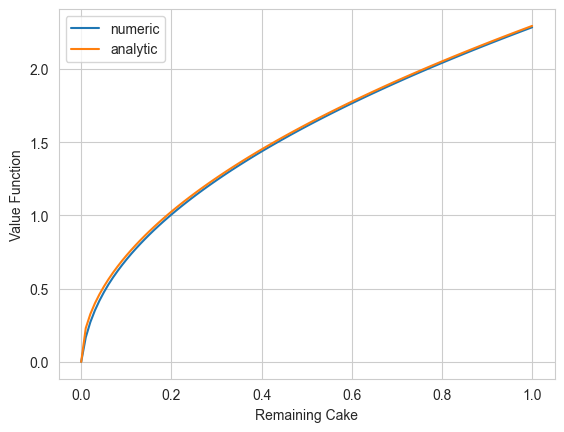

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# numeric solution
plt.plot(cake_grid, [V(c) for c in cake_grid], label="numeric")

# analytic solution
plt.plot(cake_grid, [np.sqrt(x/(1-delta**2)) for x in cake_grid], label="analytic")  

plt.xlabel("Remaining Cake")
plt.ylabel("Value Function")
plt.legend()
plt.show()

### Compare policy functions 

The true optimal policy is 

$$c^*(x) = (1-\delta^2)x.$$

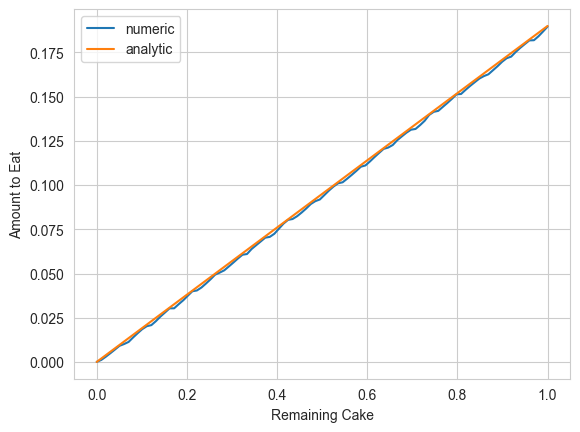

In [8]:
# numeric solution
plt.plot(cake_grid, [policy(c) for c in cake_grid], label="numeric")

# analytic solution
plt.plot(cake_grid, [(1-delta**2)*x for x in cake_grid], label="analytic")  

plt.xlabel("Remaining Cake")
plt.ylabel("Amount to Eat")
plt.legend()
plt.show()